# Libraries

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
import torchvision
torch.manual_seed(0) # Set for testing purposes, please do not change!

# Google Colab / Your Device
**Because directory system in your device(laptop) is different from google drive, so first determine this section first**

In [2]:
def directory(mode):
    if mode == 'colab':
        root_ds='/content/drive/MyDrive/gan-lab/Dataset'
        root_models = '/content/drive/MyDrive/gan-lab/Models'

    elif mode == 'pc':
        root_ds='F:\GitHub\gan-lab\Dataset'
        root_models = 'F:\GitHub\gan-lab\Models'

    return root_ds, root_models

In [3]:
# root
dir_mode = 'colab'
root_ds, root_models = directory(dir_mode)

# devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**NOTE:**
Unlike Basic GANs that you played with Nodes, in DCGANs you will play with Channels

# Information

1. We have NO any pooling layer
2. We have 2D batchnorm layer in both G and D.
3. We have NO fully connected hidden layer (nn.Linear).
4. ReLU in hidden layers - Tanh in final layer (Generators)
5. LeakyReLU in hidden layers - NO activation in final layer (Discriminator)
6. You will build a generator using 4 layers (3 hidden layers + 1 output layer)
7. You will use 3 layers in your discriminator's neural network

# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, C_noise, C_hidden, C_image):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self.gen_block(C_noise   , C_hidden*4, K=3, S=2),
            self.gen_block(C_hidden*4, C_hidden*2, K=4, S=1),
            self.gen_block(C_hidden*2, C_hidden*1, K=3, S=2),
            self.gen_block(C_hidden*1  , C_image , K=4, S=2, final_layer=True)
        )

    def gen_block(self, C_in, C_out, K, S, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(C_in, C_out, kernel_size = K, stride = S),
                nn.Tanh()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(C_in, C_out, kernel_size = K, stride = S),
                nn.BatchNorm2d(C_out),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.gen(x)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, C_image, C_hidden):
        super(Discriminator, self).__init__()

        self.dis = nn.Sequential(
            self.dis_block(C_image   , C_hidden*1, K=4, S=2),
            self.dis_block(C_hidden*1, C_hidden*2, K=4, S=2),
            self.dis_block(C_hidden*2, 1         , K=4, S=2, final_layer=True),
        )

    def dis_block(self, C_in, C_out, K, S, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(C_in, C_out, kernel_size = K, stride = S)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(C_in, C_out, kernel_size = K, stride = S),
                nn.BatchNorm2d(C_out),
                nn.LeakyReLU(inplace=True, negative_slope=0.2)
            )

    def forward(self, x):
        return self.dis(x).view(x.shape[0], -1)

# Noise

In [6]:
def get_noise(N_noise, C_noise, device='cpu'):
    return torch.randn(N_noise, C_noise, device=device).view(-1, C_noise, 1, 1)

# Losses (NEW)

$ L_D (w) = D_w(\hat{x})-D_w(x) $
<br>
$ L_G (\theta) = D(x)-D(\hat{x_\theta}) $

In [7]:
def get_loss_dis(gen, dis,
                 real,
                 N_noise, C_noise,
                 device):

    # Generate fake image by Generator
    fake = gen( get_noise(N_noise, C_noise, device=device) ).detach()
    return ( dis(fake) - dis(real) ).mean(dim=0)

In [8]:
def get_loss_gen(gen, dis,
                 N_noise, C_noise,
                 device):
    # Generate fake image by Generator
    fake = gen( get_noise(N_noise, C_noise, device=device))
    return ( -dis(fake) ).mean(dim=0)

# Helper Functions

In [9]:
def save_model(gen, dis, epoch, root, mode = None):
    # directory system in colab and pc is different.
    if mode == 'colab':
        filename = root + f'/model_epoch_{epoch}.pt'
    else:
        filename = root + f'\model_epoch_{epoch}.pt'

    torch.save({'epoch' : epoch,
              'model_dis_state_dict' : dis.state_dict(),
              'model_gen_state_dict' : gen.state_dict()},
              filename)

In [10]:
# when you want to continue training GAN from last epoch.
def load_model(gen, dis, root):
    # root = last generator and discriminator parameters that has been saved.
    # gen  = un-initialized generator
    # dis  = un-initialized discriminator

    models=torch.load(root)
    gen.load_state_dict(models['model_gen_state_dict'])
    dis.load_state_dict(models['model_dis_state_dict'])
    return models['epoch']

In [11]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [12]:
def weights_init(submodules):
    if isinstance(submodules, nn.Conv2d) or isinstance(submodules, nn.ConvTranspose2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
    if isinstance(submodules, nn.BatchNorm2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
        torch.nn.init.constant_(submodules.bias, 0)

# Hyperparameters

**WARNING**
batch_size and N_noise in some iteration it is not same!

In [13]:
# Sample numbers of noise and image
N_noise = 128
batch_size =128

# Channels of noise and image
C_noise = 64
C_image = 1

# Channels of hidden layers
C_hidden_gen = 64
C_hidden_dis = 16

# lr/epoch/disp
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

# epochs
n_epochs = 100
display_step = 500

# Real Image

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(root_ds, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

# Create Models / Criterion / Optimizers

In [15]:
# get instance from models
gen = Generator(C_noise, C_hidden_gen, C_image).to(device)
dis = Discriminator(C_image, C_hidden_dis).to(device)

# Initialize
gen = gen.apply(weights_init)
dis = dis.apply(weights_init)

# Optimizers
optim_dis = torch.optim.Adam(dis.parameters(), lr=lr, betas=(beta_1, beta_2))
optim_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

# Train

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1, step 500: Generator loss: -0.3849677502760314, critic loss: -1.112668952521868


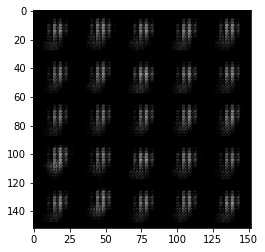

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


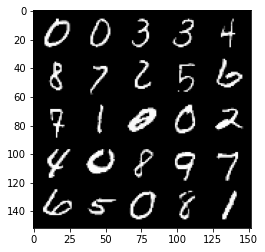

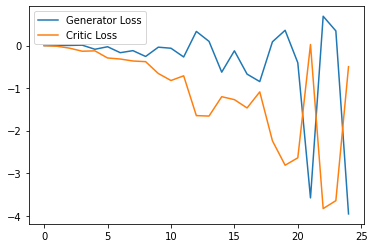

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2, step 1000: Generator loss: -0.03720010816305876, critic loss: -7.83993563605845


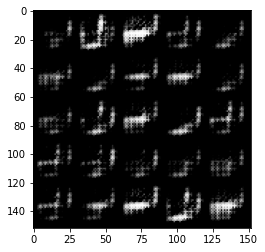

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


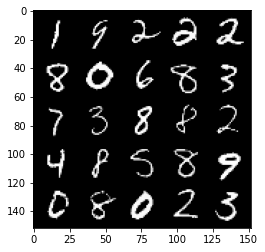

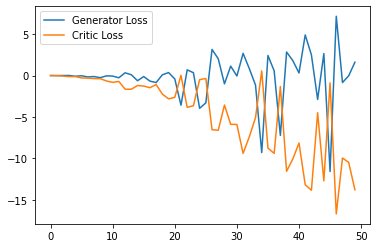

KeyboardInterrupt: 

In [16]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ### Update critic ###
        optim_dis.zero_grad()
        crit_loss = get_loss_dis(gen, dis, real, cur_batch_size, C_noise, device)
        crit_loss.backward(retain_graph=True)
        optim_dis.step()
        # Keep track of the average critic loss in this batch
        critic_losses += [crit_loss.item()]

        ### Update generator ###
        optim_gen.zero_grad()
        gen_loss = get_loss_gen(gen, dis, cur_batch_size, C_noise, device)
        gen_loss.backward()
        optim_gen.step()
        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

            fake_noise = get_noise(cur_batch_size, C_noise, device=device)
            fake = gen(fake_noise)

            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1